In [1]:
from utils.all import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6, 7, 8, 9, 10, 11], preprocess=True)
systems = set([x['system'] for x in data])
edit_types = set(data[0]['annotations'].keys())

# TODO: trivial edits on substitutions aren't being processed correctly

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json', '../annotated/batch_7_anton.json', '../annotated/batch_7_ayush.json', '../annotated/batch_7_kelly.json', '../annotated/batch_7_rachel.json', '../annotated/batch_7_vinayak.json', '../annotated/batch_7_vishnesh.json', '../annotated/batch_8_anton.json', '../annotated/batch_8_ayush.json', '../annotated/batch_8_kelly.json', '../annotated/batch_8_rachel.json', '../annotated/batch_8_vinayak.json', '../annotated/batch_8_vishnesh.json', '../annotated/batch_9_ayush.json', '../annotated/batch_9_kelly.json', '../annotated/batch_9_rachel.json', '../annotated/

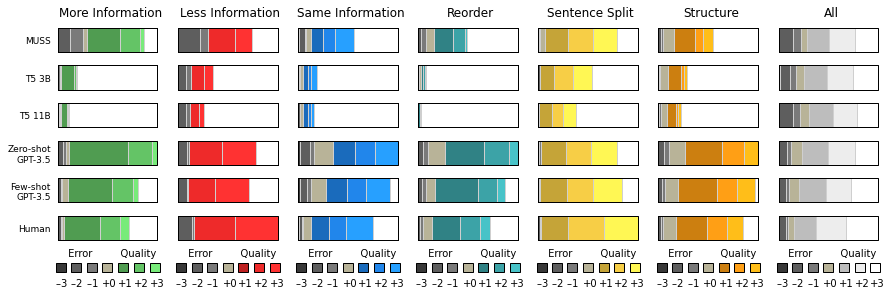

In [5]:
edit_ratings_barh(data) # include_all=False

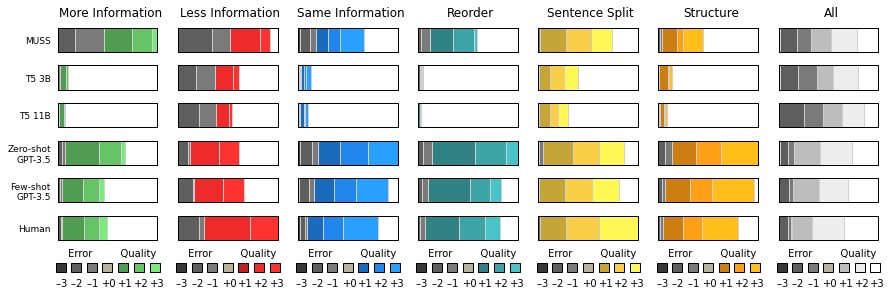

In [3]:
edit_ratings_barh(data, size_weighted=True)

In [4]:
break

SyntaxError: 'break' outside loop (<ipython-input-4-6aaf1f276005>, line 1)

In [ ]:
# average_scores: Averages our scores before plotting
for sent in data:
    sent['ed'] = edit_dist(sent['original'], sent['simplified'])

KeyboardInterrupt: 

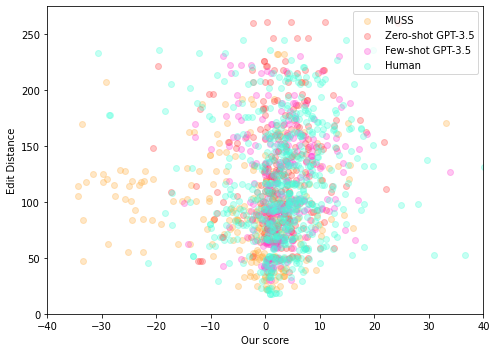

In [ ]:
simpeval=False

# Averages scores across sentences with the same ID
# new_data = copy.deepcopy(data)
# for id_ in set([sent['id'] for sent in data]):
#     sents = [sent for sent in data if sent['id'] == id_]
#     new_score = avg([sent['score'] for sent in sents])
#     for i in range(len(new_data)):
#         if new_data[i]['id'] == id_:
#             new_data[i]['score'] = new_score
# data = new_data

total_sent = 0

selected_systems = [
    'new-wiki-1/Muss',
    'aggregated/human',
    'new-wiki-1/GPT-3-zero-shot',
    'new-wiki-1/GPT-3-few-shot',
]

for system in [s for s in all_system_labels if s in selected_systems]:
    # Also graph SimpEval Scores
    # scores = [(avg(sent['simpeval_scores'], prec=10), sent['ed']) for sent in data if sent['system'] == system]
    
    if system == 'aggregated/human':
        selected = [s for s in data if 'Human' in s['system']]
    else:
        selected = [s for s in data if s['system'] == system]


    scores = [(sent['score'], sent['ed']) for sent in selected]
    plt.scatter([p[0] for p in scores], [p[1] for p in scores], c=color_mapping[system], alpha=0.3, label=system_name_mapping[system])
    total_sent += len(scores)

plt.xlabel('Our score')
plt.ylabel('Edit Distance')

# set plt y scale to log
# plt.xscale('log')
# plt.yscale('log')

plt.xlim(-40, 40)
plt.ylim(0, 275)

plt.gcf().set_size_inches(7, 5)
plt.legend()
out_filename = f'img/edit-distance-vs-score.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

In [ ]:
break

SyntaxError: 'break' outside loop (<ipython-input-4-6aaf1f276005>, line 1)

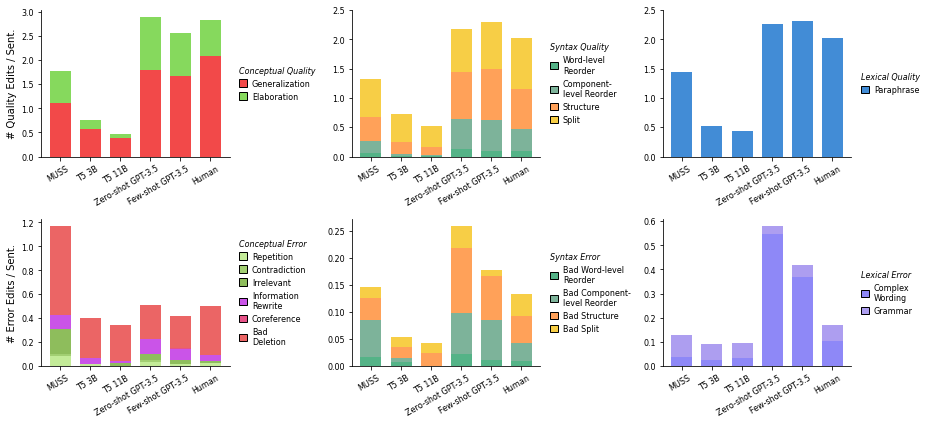

In [ ]:
savefig = False

fig, ax = plt.subplots(2, 3, figsize=(13, 6))
width = 0.7

for plt_idx, family in enumerate(Family):
    out = get_edits_by_family(data, family)
    # Get the system labels by preserving the order of systems
    system_labels = [x for x in system_name_mapping if x in out.keys()]
    x = np.arange(len(system_labels))

    # Graph the quality edits
    quality_data = {system : out[system]['quality'] for system, _ in out.items()}
    bottom = [0 for x in range(len(system_labels))]
    if family == Family.CONTENT:
        quality_iterator = Information
    elif family == Family.SYNTAX:
        quality_iterator = [x for x in ReorderLevel] + [Edit.STRUCTURE] + [Edit.SPLIT]
    elif family == Family.LEXICAL:
        quality_iterator = [Information.SAME]
    for quality_type in quality_iterator:
        val = [quality_data[label][quality_type] for label in system_labels]
        if sum(val) != 0:
            # Custom labels
            label = quality_type.value
            # if family == Family.SYNTAX:
            #     label = 'Quality ' + quality_type.value.lower() + ' edit'
            if quality_type == Information.SAME:
                label = 'Paraphrase'

            ax[0,plt_idx].bar(x, val, width, bottom=bottom, label=label, color=color_mapping[quality_type])
        bottom = [bottom[i] + val[i] for i in range(len(val))]

    # Graph the error edits
    error_data = {system : out[system]['error'] for system, _ in out.items()}
    bottom = [0 for x in range(len(system_labels))]
    if family == Family.CONTENT:
        error_iterator = [e for e in Error if e != Error.UNNECESSARY_INSERTION]
    elif family == Family.SYNTAX:
        error_iterator = [x for x in ReorderLevel] + [Edit.STRUCTURE] + [Edit.SPLIT]
    elif family == Family.LEXICAL:
        error_iterator = [Error.COMPLEX_WORDING, Quality.ERROR, Error.UNNECESSARY_INSERTION]
    for error_type in error_iterator:
        val = [error_data[label][error_type] for label in system_labels]

        # This is a really awful solution, but it would be too much to change the classification of this error
        if family == Family.LEXICAL and error_type == Error.UNNECESSARY_INSERTION:
            tmp = get_edits_by_family(data, Family.CONTENT)
            tmp = {system : tmp[system]['error'] for system, _ in tmp.items()}
            val = [tmp[label][Error.UNNECESSARY_INSERTION] for label in system_labels]

        if sum(val) != 0:
            # Custom labels
            label = error_type.value
            if family == Family.SYNTAX or Family.LEXICAL:
                if label == 'Error':
                    label = 'Grammar'
                # label += ' Error'

            ax[1,plt_idx].bar(x, val, width, bottom=bottom, label=label, color=color_mapping[error_type])
        bottom = [bottom[i] + val[i] for i in range(len(val))]

    displayed_x_labels = [system_name_mapping[label] for label in system_labels]

    font_size = 8

    ax[0,plt_idx].tick_params(labelsize=font_size)
    ax[1,plt_idx].tick_params(labelsize=font_size)
    
    ax[0,plt_idx].set_xticklabels(['none'] + displayed_x_labels, rotation=30, ha="right")
    ax[1,plt_idx].set_xticklabels(['none'] + displayed_x_labels, rotation=30, ha='right')

    ax[0,plt_idx].spines[['right', 'top']].set_visible(False)
    ax[1,plt_idx].spines[['right', 'top']].set_visible(False)

    trans = mtrans.Affine2D().translate(10, 0)
    for t in ax[0,plt_idx].get_xticklabels() + ax[1,plt_idx].get_xticklabels():
        t.set_transform(t.get_transform()+trans)

    # ax[1,plt_idx].set_yticklabels([])

    font_size = 8
    legend_loc = (0.5, -0.35)

    # if family == Family.LEXICAL:
    #     # ax[0,plt_idx].set_xlabel('System')
    #     # ax[1,plt_idx].set_xlabel('System')
    #     legend_loc = (0.5, -0.45)
    # elif family == Family.CONTENT:
    #     # ax[0,plt_idx].set_title('Success ↑ (# Quality / Sent.)')
    #     # ax[1,plt_idx].set_title('Failure ↓ (# Error / Sent.)')

    if family == Family.CONTENT:
        ax[0,plt_idx].set_ylabel('# Quality Edits / Sent.')
        ax[1,plt_idx].set_ylabel('# Error Edits / Sent.')

    # Legends below graphs
    # ax[0,plt_idx].legend(loc='upper center', bbox_to_anchor=legend_loc,
    #     fancybox=True, ncol=2, borderaxespad=1.,fontsize=font_size,
    #     facecolor='white',edgecolor='black',framealpha=1,frameon=False,
    #     columnspacing=1,handlelength=1,handleheight=1,handletextpad=0.4,
    #     borderpad=0.2)

    # ax[1,plt_idx].legend(loc='upper center', bbox_to_anchor=legend_loc,
    #     fancybox=True, ncol=2, borderaxespad=1.,fontsize=font_size,
    #     facecolor='white',edgecolor='black',framealpha=1,frameon=False,
    #     columnspacing=1,handlelength=1,handleheight=1,handletextpad=0.4,
    #     borderpad=0.2)

    legend_loc = (1, 0.5)

    ax[0,plt_idx].legend(loc='center left', bbox_to_anchor=legend_loc,
        fancybox=True, ncol=1, borderaxespad=1.,fontsize=font_size,
        facecolor='white',edgecolor='black',framealpha=1,frameon=False,
        columnspacing=1,handlelength=1,handleheight=1,handletextpad=0.6,
        borderpad=0.2, title=f'{family.value} Quality', alignment='left', 
        title_fontproperties={'weight': 500, 'size': font_size, 'style': 'italic'})

    ax[1,plt_idx].legend(loc='center left', bbox_to_anchor=legend_loc,
        fancybox=True, ncol=1, borderaxespad=1.,fontsize=font_size,
        facecolor='white',edgecolor='black',framealpha=1,frameon=False,
        columnspacing=1,handlelength=1,handleheight=1,handletextpad=0.6,
        borderpad=0.2, title=f'{family.value} Error', alignment='left', 
        title_fontproperties={'weight': 500, 'size': font_size, 'style': 'italic'})

    for ha in ax[0,plt_idx].legend_.legendHandles + ax[1,plt_idx].legend_.legendHandles:
        ha.set_edgecolor("black")

    for i in range(2):
        for text in ax[i,plt_idx].legend_.texts:
            new_text = text.get_text().replace(' ', '\n').replace('t-', 't-\n')
            if family == Family.SYNTAX and i == 1:
                new_text = f'Bad {new_text}'
            if 'level' in new_text:
                new_text = f'{new_text} Reorder'
                new_text = new_text.replace('Word-level ', 'Word-level\n')
            text.set_text(new_text)
    

    # Set the margins a little higher than the max value
    max_quality = max([sum(x.values()) for x in quality_data.values()])
    tick_range_quality = np.arange(0, max_quality*1.2, step=0.5)
    ax[0,plt_idx].set_yticks(tick_range_quality)

    # Calculate tick values (I don't use this)
    # ax[0,plt_idx].set_yticks([i*round(max(bottom)/5) for i in range(6)])

    # max_error = max([sum(x.values()) for x in error_data.values()])
    # tick_range_error = np.arange(0, max_error*1.2, step=0.2)
    # ax[1,plt_idx].set_yticks(tick_range_error)

    # tick_range_quality = np.arange(0, max([sum(x.values()) for x in quality_data.values()]) + 10, step=50)
    # max_error = 101
    # if family == Family.CONTENT: 
    #     max_error = 201
    # tick_range_error = np.arange(0, max_error, step=20) # (len(data)/len(out.keys())) + 10        
    # ax[1,plt_idx].set_yticks(tick_range_error)

# Add titles
# fig.suptitle('Conceptual Edits', fontsize=14)
# plt.figtext(0.5, (2/3) - 0.023, "Syntax Edits", va="center", ha="center", size=14)
# plt.figtext(0.5, (1/3), "Lexical Edits", va="center", ha="center", size=14)

# plt.figtext('Conceptual Edits', fontsize=14)
# plt.figtext(0.5, (2/3) - 0.023, "Syntax Edits", va="center", ha="center", size=14)
# plt.figtext(0.5, (1/3), "Lexical Edits", va="center", ha="center", size=14)

# ax[0, 0].set_title('Conceptual Quality', fontsize=14)
# ax[0, 1].set_title('Syntax Quality', fontsize=14)
# ax[0, 2].set_title('Lexical Quality', fontsize=14)

# ax[1, 0].set_title('Conceptual Error', fontsize=14)
# ax[1, 1].set_title('Syntax Error', fontsize=14)
# ax[1, 2].set_title('Lexical Error', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=1.2)
if savefig:
    out_filename = f'img/edit-ratings-all-separated.pdf'
    plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
    plt.close(fig)
else:
    plt.show()

In [ ]:
savefig = True

fig, ax_quality = plt.subplots(1, 3, figsize=(13, 3.5))
width = 0.7

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'TW Cen MT'

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.sans-serif'] = 'Times New Roman'

font_size_legend = 11
font_size_x_labels = 12 
font_size_y_label = 12
font_size_title = 15
legend_loc = (1, 0.5)

def fix_text(text, syntax_error=False):
    new_text = text.replace(' ', '\n').replace('t-', 't-\n')
    if syntax_error:
        new_text = f'Bad {new_text}'
    if 'level' in new_text:
        new_text = f'{new_text} Reorder'
        new_text = new_text.replace('Word-level ', 'Word-level\n')
    if 'Grammar' in new_text:
        new_text = new_text.replace('Grammar', 'Grammar\nError')
    return new_text

for plt_idx, family in enumerate(Family):
    out = get_edits_by_family(data, family)
    # Get the system labels by preserving the order of systems
    system_labels = [x for x in system_name_mapping if x in out.keys()]
    x = np.arange(len(system_labels))

    # Graph the quality edits
    quality_data = {system : out[system]['quality'] for system, _ in out.items()}
    bottom = [0 for x in range(len(system_labels))]
    if family == Family.CONTENT:
        quality_iterator = [Information.MORE, Information.LESS]
    elif family == Family.SYNTAX:
        quality_iterator = [x for x in ReorderLevel] + [Edit.STRUCTURE] + [Edit.SPLIT]
    elif family == Family.LEXICAL:
        quality_iterator = [Information.SAME]
    for quality_type in quality_iterator:
        val = [quality_data[label][quality_type] for label in system_labels]
        if sum(val) != 0:
            # Custom labels
            label = quality_type.value
            # if family == Family.SYNTAX:
            #     label = 'Quality ' + quality_type.value.lower() + ' edit'
            if quality_type == Information.SAME:
                label = 'Paraphrase'

            ax_quality[plt_idx].bar(x, val, width, bottom=bottom, label=label, color=color_mapping[quality_type])
        bottom = [bottom[i] + val[i] for i in range(len(val))]

    ax_quality[plt_idx].tick_params(labelsize=font_size_x_labels)
    ax_quality[plt_idx].set_xticks(np.arange(len(system_labels)))
    ax_quality[plt_idx].set_xticklabels(displayed_x_labels, rotation=30, ha="right")
    ax_quality[plt_idx].spines[['right', 'top']].set_visible(False)

    if family == Family.CONTENT:
        ax_quality[plt_idx].set_ylabel('# Quality Edits / Sent.', fontsize=font_size_y_label)

    handles, labels = ax_quality[plt_idx].get_legend_handles_labels()
    ax_quality[plt_idx].legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=legend_loc,
        fancybox=True, ncol=1, borderaxespad=1.,fontsize=font_size_legend,
        facecolor='white',edgecolor='black',framealpha=1,frameon=False,
        columnspacing=1,handlelength=1,handleheight=1,handletextpad=0.6,
        borderpad=0.2, alignment='left', 
        # title=f'{family.value} Quality', title_fontproperties={'weight': 500, 'size': font_size_legend, 'style': 'italic'}
        )

    for ha in ax_quality[plt_idx].legend_.legendHandles:
        ha.set_edgecolor("black")

    trans = mtrans.Affine2D().translate(10, 0)
    for t in ax_quality[plt_idx].get_xticklabels():
        t.set_transform(t.get_transform()+trans)

    # Set the margins a little higher than the max value
    max_quality = max([sum(x.values()) for x in quality_data.values()])
    tick_range_quality = np.arange(0, max_quality*1.2, step=0.5)
    ax_quality[plt_idx].set_yticks(tick_range_quality)

    for text in ax_quality[plt_idx].legend_.texts:
        text.set_text(fix_text(text.get_text()))

    ax_quality[0].set_title('Conceptual Quality', fontsize=font_size_title)
    ax_quality[1].set_title('Syntax Quality', fontsize=font_size_title)
    ax_quality[2].set_title('Lexical Quality', fontsize=font_size_title)

plt.tight_layout()
if savefig:
    out_filename = f'img/quality-edits.pdf'
    plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
    plt.close(fig)
else:
    plt.show()

fig, ax_error = plt.subplots(1, 3, figsize=(13, 3.5))

for plt_idx, family in enumerate(Family):
    out = get_edits_by_family(data, family)
    # Get the system labels by preserving the order of systems
    system_labels = [x for x in system_name_mapping if x in out.keys()]
    x = np.arange(len(system_labels))

    # Graph the error edits
    error_data = {system : out[system]['error'] for system, _ in out.items()}
    bottom = [0 for x in range(len(system_labels))]
    if family == Family.CONTENT:
        error_iterator = [e for e in Error if e != Error.UNNECESSARY_INSERTION]
    elif family == Family.SYNTAX:
        error_iterator = [x for x in ReorderLevel] + [Edit.STRUCTURE] + [Edit.SPLIT]
    elif family == Family.LEXICAL:
        error_iterator = [Error.COMPLEX_WORDING, Quality.ERROR, Error.UNNECESSARY_INSERTION]
    for error_type in error_iterator:
        val = [error_data[label][error_type] for label in system_labels]

        # This is a really awful solution, but it would be too much to change the classification of this error
        if family == Family.LEXICAL and error_type == Error.UNNECESSARY_INSERTION:
            tmp = get_edits_by_family(data, Family.CONTENT)
            tmp = {system : tmp[system]['error'] for system, _ in tmp.items()}
            val = [tmp[label][Error.UNNECESSARY_INSERTION] for label in system_labels]

        if sum(val) != 0:
            # Custom labels
            label = error_type.value
            if family == Family.SYNTAX or Family.LEXICAL:
                if label == 'Error':
                    label = 'Grammar'
                # label += ' Error'

            color = color_mapping[error_type]
            if family == Family.SYNTAX:
                color = color_mapping_override[error_type]
            ax_error[plt_idx].bar(x, val, width, bottom=bottom, label=label, color=color)
        bottom = [bottom[i] + val[i] for i in range(len(val))]

    displayed_x_labels = [system_name_mapping[label] for label in system_labels]

    ax_error[plt_idx].tick_params(labelsize=font_size_x_labels)
    ax_error[plt_idx].set_xticks(np.arange(len(system_labels)))
    ax_error[plt_idx].set_xticklabels(displayed_x_labels, rotation=30, ha='right')
    ax_error[plt_idx].spines[['right', 'top']].set_visible(False)

    if family == Family.CONTENT:
        ax_error[plt_idx].set_ylabel('# Error Edits / Sent.', fontsize=font_size_y_label)

    handles, labels = ax_error[plt_idx].get_legend_handles_labels()
    ax_error[plt_idx].legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=legend_loc,
        fancybox=True, ncol=1, borderaxespad=1.,fontsize=font_size_legend,
        facecolor='white',edgecolor='black',framealpha=1,frameon=False,
        columnspacing=1,handlelength=1,handleheight=1,handletextpad=0.6,
        borderpad=0.2, alignment='left', 
        # title=f'{family.value} Error', title_fontproperties={'weight': 500, 'size': font_size_legend, 'style': 'italic'}
        )

    for ha in ax_error[plt_idx].legend_.legendHandles:
        ha.set_edgecolor("black")

    trans = mtrans.Affine2D().translate(10, 0)
    for t in ax_error[plt_idx].get_xticklabels():
        t.set_transform(t.get_transform()+trans)

    for text in ax_error[plt_idx].legend_.texts:
        text.set_text(fix_text(text.get_text(), syntax_error=(family == Family.SYNTAX)))

    # Set the margins a little higher than the max value
    step_dict = {
        Family.CONTENT: 0.2,
        Family.SYNTAX: 0.05,
        Family.LEXICAL: 0.1,
    }
    max_error = max([sum(x.values()) for x in error_data.values()])
    tick_range_error = np.arange(0, max_error*1.2, step=step_dict[family])
    ax_error[plt_idx].set_yticks(tick_range_error)

    ax_error[0].set_title('Conceptual Error', fontsize=font_size_title)
    ax_error[1].set_title('Syntax Error', fontsize=font_size_title)
    ax_error[2].set_title('Lexical Error', fontsize=font_size_title)

plt.tight_layout()
if savefig:
    out_filename = f'img/error-edits.pdf'
    plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
    plt.close(fig)
else:
    plt.show()